In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random

torch.manual_seed(39)
torch.cuda.manual_seed(39)
random.seed(39)
np.random.seed(39)

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)
    
class SingleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.single_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.single_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [36]:
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        #self.depth_layer = SoftAttnDepth()

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        #x =torch.sigmoid(x)
        #x,pr = self.depth_layer(x)
        return x

In [69]:
checkpoint = torch.load('E:/gopro/experiment/2021_06_11_19_57_48_UNet_BLE/model_best.pth.tar', map_location=lambda storage, loc: storage.cuda(0))

In [70]:
model=UNet().cuda()
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

(720, 1280, 3)


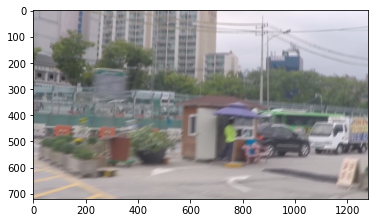

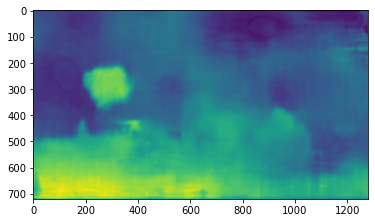

In [73]:
from PIL import Image, ImageOps
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from PIL import Image, ImageOps
#from skimage import filters
from PIL import ImageFilter
import random

blur=Image.open('E:/gopro/GOPRO_Large/test/GOPR0410_11_00/blur/000162.png')
#blur=Image.open('E:/gopro/BLE_all/test/GOPR0410_11_00/001771.png')
#blur=Image.open('E:/Downloads/BSD/BSD_2ms16ms/test/072/Blur/RGB/00000042.png')
#blur = blur.crop((200,200,640,480))
#blur = blur.resize((1280,1280))
blur = np.asarray(blur)
print(blur.shape)
blur = np.ascontiguousarray(blur.transpose((2, 0, 1)))
blur = torch.from_numpy(blur).float()/255.0*2-1
plt.figure()
plt.imshow((blur.permute(1,2,0)+1)/2)
ble=model(blur.unsqueeze(0).cuda())
ble=ble.detach().to('cpu').numpy()
plt.figure()
plt.imshow(ble.squeeze())